# Human In the Loop

Review For human-in-the-loop, we often want to see our graph outputs as its running.
We laid the foundations for this with streaming.

Goals Now, let's talk about the motivations for human-in-the-loop:
- Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action
- Debugging - We can rewind the graph to reproduce or avoid issues
- Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

In [149]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from typing import TypedDict,Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from dotenv import load_dotenv
load_dotenv()

True

In [150]:
llm=ChatGroq(model='llama-3.1-8b-instant')

In [151]:
### Custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add,multiply,divide]
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [152]:
llm_tools=llm.bind_tools(tools)

In [153]:
system_msg=SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

In [154]:
## node
def assistant(state:MessagesState):
    return {"messages":[llm_tools.invoke([system_msg] + state["messages"])]}

In [155]:

graph=StateGraph(MessagesState)

graph.add_node('assistant',assistant)
graph.add_node('tools',ToolNode(tools))

graph.add_edge(START,'assistant')
graph.add_conditional_edges('assistant',
                            tools_condition,
                            )
graph.add_edge('tools','assistant')

checkpointer=MemorySaver()

workflow=graph.compile(checkpointer=checkpointer,interrupt_before=['assistant'])

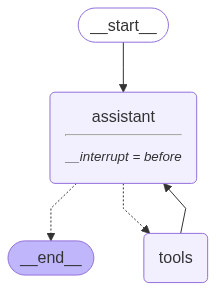

In [156]:
workflow

In [157]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="what is 10 + 20")}

In [158]:
for event in workflow.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is 10 + 20


In [159]:
state=workflow.get_state(thread) # current most recent state
state.next

('assistant',)

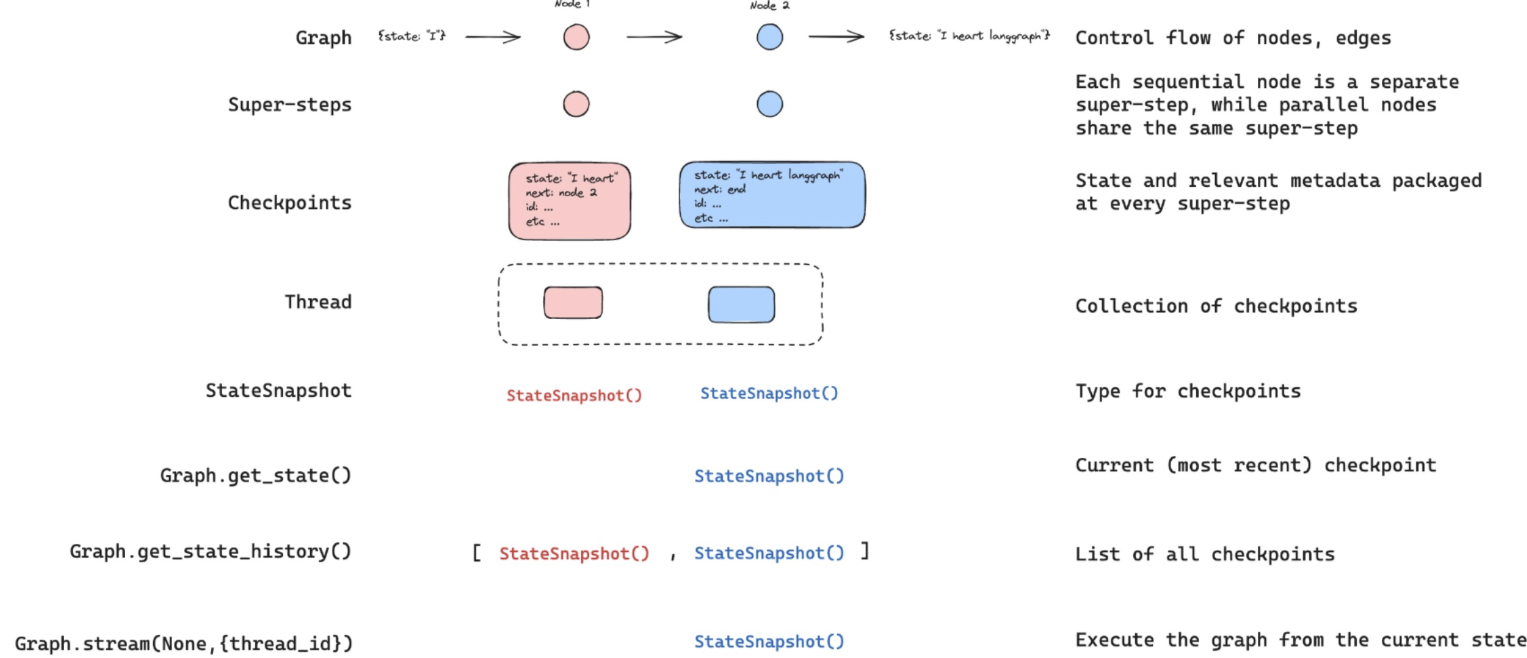

In [160]:
for i in workflow.get_state_history(thread): # all state
    print(i)

StateSnapshot(values={'messages': [HumanMessage(content='what is 10 + 20', additional_kwargs={}, response_metadata={}, id='89fcc192-636c-42e2-b697-952c91df07c4')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f08e6b8-afc8-6060-8000-2dbef9b75da8'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-10T17:28:19.293386+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f08e6b8-afc6-6496-bfff-396bcd2f7762'}}, tasks=(PregelTask(id='c7a51806-272e-a5d7-f7d8-1ce049f87a63', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())
StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f08e6b8-afc6-6496-bfff-396bcd2f7762'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-09-10T17:2

In [161]:
for event in workflow.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is 10 + 20
================================== Ai Message ==================================
Tool Calls:
  add (2prgqaz3c)
 Call ID: 2prgqaz3c
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: add

30


In [162]:
for event in workflow.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: add

30
================================== Ai Message ==================================
Tool Calls:
  multiply (v57vccd0k)
 Call ID: v57vccd0k
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: multiply

200


In [163]:
# Edit Human Feedback
for event in workflow.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

200


In [164]:
workflow.update_state(thread,{
    'messages':HumanMessage(content='what is 10 multiply 20')
})

{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08e6b8-b950-6d66-8007-4e75fe96a08f'}}

In [165]:
for i in workflow.get_state(thread).values['messages']:
    print(i)

content='what is 10 + 20' additional_kwargs={} response_metadata={} id='89fcc192-636c-42e2-b697-952c91df07c4'
content='' additional_kwargs={'tool_calls': [{'id': '2prgqaz3c', 'function': {'arguments': '{"a":10,"b":20}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 374, 'total_tokens': 392, 'completion_time': 0.025377464, 'prompt_time': 0.049856828, 'queue_time': 0.047072122, 'total_time': 0.075234292}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--8df90a2b-0b3e-46cf-a465-e0eadd543583-0' tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 20}, 'id': '2prgqaz3c', 'type': 'tool_call'}] usage_metadata={'input_tokens': 374, 'output_tokens': 18, 'total_tokens': 392}
content='30' name='add' id='d0cde67f-4579-43d8-a1c8-9a5265ed3cef' tool_call_id='2prgqaz3c'
content='' additional_kwargs={'tool_calls': [{'id': '

In [166]:

for event in workflow.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is 10 multiply 20
================================== Ai Message ==================================
Tool Calls:
  multiply (p1vktzr3q)
 Call ID: p1vktzr3q
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: multiply

200


In [167]:

workflow.get_state(thread).next

('assistant',)

In [168]:
for i in workflow.get_state(thread).values['messages']:
    print(i)

content='what is 10 + 20' additional_kwargs={} response_metadata={} id='89fcc192-636c-42e2-b697-952c91df07c4'
content='' additional_kwargs={'tool_calls': [{'id': '2prgqaz3c', 'function': {'arguments': '{"a":10,"b":20}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 374, 'total_tokens': 392, 'completion_time': 0.025377464, 'prompt_time': 0.049856828, 'queue_time': 0.047072122, 'total_time': 0.075234292}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--8df90a2b-0b3e-46cf-a465-e0eadd543583-0' tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 20}, 'id': '2prgqaz3c', 'type': 'tool_call'}] usage_metadata={'input_tokens': 374, 'output_tokens': 18, 'total_tokens': 392}
content='30' name='add' id='d0cde67f-4579-43d8-a1c8-9a5265ed3cef' tool_call_id='2prgqaz3c'
content='' additional_kwargs={'tool_calls': [{'id': '

In [169]:
for event in workflow.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

200
================================== Ai Message ==================================
Tool Calls:
  divide (sfc2y4wey)
 Call ID: sfc2y4wey
  Args:
    a: 100
    b: 5
================================= Tool Message =================================
Name: divide

20.0


# Workflow will wait for the human input

In [170]:

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")




def human_feedback(state:MessagesState):
    pass


def assistant(state:MessagesState):
    return {"messages": [llm_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)



builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools","human_feedback")

memory=MemorySaver()
graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

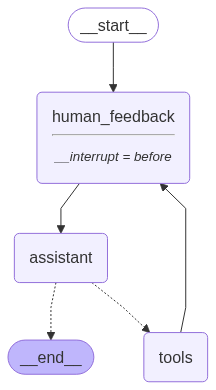

In [171]:
graph

In [172]:

initial_input = {"messages": "Multiply 2 and 3"}


thread = {"configurable": {"thread_id": "5"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


user_input=input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")


for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

4 + 4
================================== Ai Message ==================================
Tool Calls:
  multiply (my3gracgb)
 Call ID: my3gracgb
  Args:
    a: 2
    b: 3
  add (f55gvsvwn)
 Call ID: f55gvsvwn
  Args:
    a: 4
    b: 4
================================= Tool Message =================================
Name: add

8


In [174]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

2.0
================================== Ai Message ==================================
Tool Calls:
  divide (c2q2831k9)
 Call ID: c2q2831k9
  Args:
    a: 8
    b: 4
================================= Tool Message =================================
Name: divide

2.0
